In [1]:
%matplotlib inline

import sys
sys.path.append("../")
import copy
import itertools
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pydlm import dlm, trend, seasonality, dynamic, autoReg


import helpers
from src import dataset

In [2]:
excel_file = "20160921-analysisofestimatedarrivals.xlsx"
data = dataset.load_excel(excel_file)
data = dataset.load_all_regions(data)

In [3]:
df_italy = data["italy"] # Arrivals to Italy
df_greek_island = data["greek_island"] # Arrivals to Greek Island
df_mainland_greece = data["mainland_greece"] # Arrivals to Mainland greece
df_fyrom = data["fyrom"] # Arrivals to fYRoM
df_serbia = data["serbia"] # Arrivals to Serbia
df_croatia = data["croatia"] # Arrivals to Croatia
df_hungry = data["hungry"] # Arrivals to Hungry
df_slovenia = data["slovenia"] # Arrivals to Slovenia
df_austria = data["austria"] # Arrivals to Austria

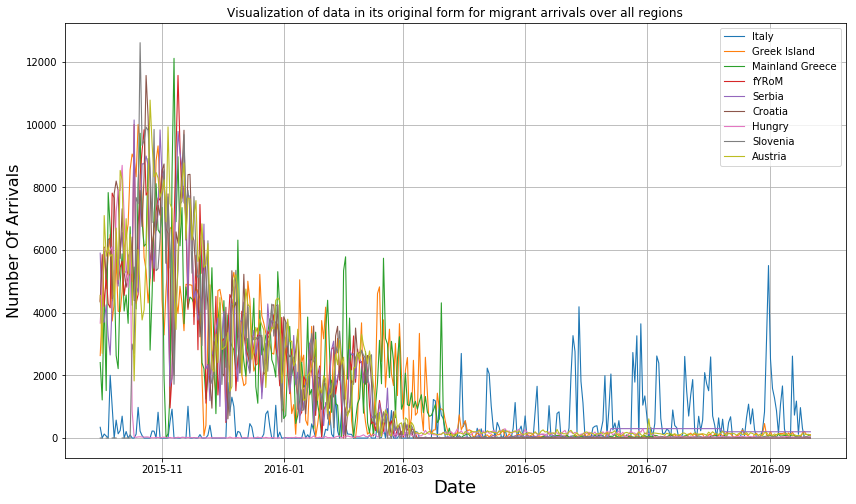

In [4]:
# Plot time series over all regions
plt.figure(figsize=(14,8))
plt.plot(df_italy.index, df_italy.iloc[:, 0], label="Italy", linewidth=1.1)
plt.plot(df_greek_island.index, df_greek_island.iloc[:, 0], label="Greek Island", linewidth=1.1)
plt.plot(df_mainland_greece.index, df_mainland_greece.iloc[:, 0], label="Mainland Greece", linewidth=1.1)
plt.plot(df_fyrom.index, df_fyrom.iloc[:, 0], label="fYRoM", linewidth=1.1)
plt.plot(df_serbia.index, df_serbia.iloc[:, 0], label="Serbia", linewidth=1.1)
plt.plot(df_croatia.index, df_croatia.iloc[:, 0], label="Croatia", linewidth=1.1)
plt.plot(df_hungry.index, df_hungry.iloc[:, 0], label="Hungry", linewidth=1.1)
plt.plot(df_slovenia.index, df_slovenia.iloc[:, 0], label="Slovenia", linewidth=1.1)
plt.plot(df_austria.index, df_austria.iloc[:, 0], label="Austria", linewidth=1.1)
plt.legend(loc="best")
plt.title("Visualization of data in its original form for migrant arrivals over all regions")
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number Of Arrivals', fontsize=16)
plt.grid(True)
plt.show()

In [5]:
df = df_austria # Seriies to test
column_name = df.columns[0]
print("Region: (%s),  will be used for the analysis" % column_name)

Region: (Arrivals to Austria),  will be used for the analysis


In [6]:
fill_method = "ffill"
df.fillna(0, inplace=True)
df[df.columns[0]] = df[column_name].replace(to_replace=0, method=fill_method) # Replace 0 in series

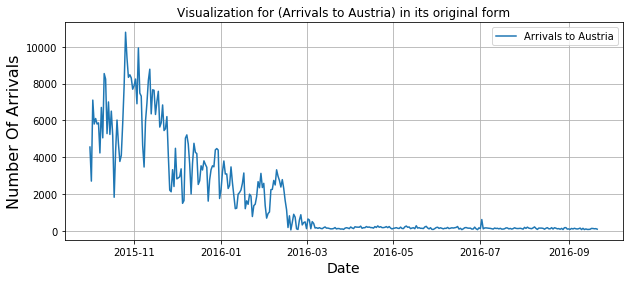

In [7]:
# Plot current selected region for analysus
plt.figure(figsize=(10,4))
plt.plot(df, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %df.columns[0])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number Of Arrivals', fontsize=16)
plt.grid()
plt.show()

In [8]:
df.describe()

,Arrivals to Austria
count,357.000000
mean,1733.781513
std,2429.884425
min,50.000000
25%,133.000000
50%,196.000000
75%,2764.000000
max,10784.000000


In [9]:
# Make copy of original df for later purpose
df_to_orig = copy.deepcopy(df)
df_to_orig[column_name] = df_to_orig[column_name].replace(to_replace=0, method=fill_method)
df_to_orig = df_to_orig.fillna(method=fill_method)

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


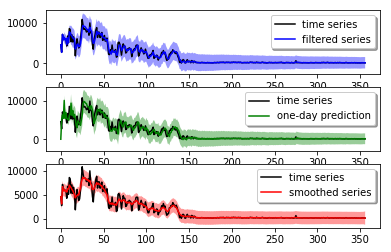

RMSE: 912.1868225594551


In [10]:
model = dlm(df[column_name])
model = model + trend(degree=1, discount=0.72, name='trend component') # For Italy dicount=0.90 and for autria=0.72
model = model + seasonality(period=2, discount=0.99, name='seasonality component') # For Italy dicount=0.90 and for austria = 0.99

model.fit()
model.plot()
predictions = list(np.array(model.result.predictedObs).flatten())
r2 = r2_score(df, predictions)
rmse = np.sqrt(model.getMSE())
print('RMSE:', rmse)
# print('R2:', r2)